# SacFC - All Products Training Dataset
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
lkupclientid = 31 # SACFC
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(12155, 53)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12155 entries, 0 to 12154
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            12155 non-null  int64  
 1   dimCustomerMasterId     12155 non-null  int64  
 2   year                    12155 non-null  int64  
 3   productGrouping         12155 non-null  object 
 4   totalSpent              12155 non-null  float64
 5   recentDate              12155 non-null  object 
 6   attendancePercent       12155 non-null  float64
 7   renewedBeforeDays       12155 non-null  int64  
 8   isBuyer                 12155 non-null  object 
 9   source_tenure           12155 non-null  int64  
 10  tenure                  12155 non-null  int64  
 11  distToVenue             0 non-null      object 
 12  totalGames              12155 non-null  int64  
 13  recency                 12155 non-null  int64  
 14  missed_games_1          12155 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
                "dimCustomerMasterId",
                "attendancePercent",
                "clickToOpenRatio",
                "clickToSendRatio",
                "distToVenue",
                "email",
                "inperson_contact",
                "internal_note",
                "left_message",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "openToSendRatio",
                "phonecall",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (5392, 21)
Unseen Data For Predictions: (951, 21)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "clickToOpenRatio",
                "clickToSendRatio",
                "distToVenue",
                "email",
                "inperson_contact",
                "internal_note",
                "left_message",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "openToSendRatio",
                "phonecall",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8102,0.8575,0.8975,0.8486,0.8722,0.5043,0.5083,0.3790
lr,Logistic Regression,0.7386,0.7359,0.9589,0.7492,0.8411,0.1624,0.2142,0.4010


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8410,0.8921,0.8912,0.8886,0.8899,0.6036,0.6036
1,0.7887,0.8203,0.9094,0.8179,0.8612,0.4235,0.4341
2,0.8083,0.8623,0.8792,0.8584,0.8687,0.5140,0.5145
3,0.8035,0.8484,0.8852,0.8493,0.8669,0.4925,0.4940
4,0.8210,0.8600,0.9215,0.8449,0.8815,0.5182,0.5265
5,0.8122,0.8670,0.8973,0.8510,0.8735,0.5101,0.5128
6,0.8013,0.8371,0.8879,0.8444,0.8656,0.4857,0.4880
7,0.7948,0.8450,0.8788,0.8430,0.8605,0.4727,0.4742
8,0.8231,0.8664,0.9273,0.8430,0.8831,0.5232,0.5334
9,0.8079,0.8766,0.8970,0.8457,0.8706,0.4990,0.5022


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/data.py:208: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference[df_inference["productGrouping"] ==  'Full Season' ]
df_inference = df_inference.fillna(0)
df_inference.shape

(1423, 53)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,source_tenure,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
10410,31,457921626,2022,Full Season,576.00,2022-04-02,0.500000,193,TRUE,1825,...,0,0,0.0,0,22,0,0,0,0.7898,0.2102
10411,31,457921801,2022,Full Season,1462.56,2022-04-02,0.600000,140,TRUE,730,...,0,0,0.0,0,22,0,0,1,0.1507,0.8493
10412,31,457922141,2022,Full Season,1830.00,2022-06-04,0.500000,183,TRUE,365,...,0,0,0.0,0,22,0,0,1,0.1392,0.8608
10413,31,457922153,2022,Full Season,651.96,2022-04-30,1.000000,95,TRUE,365,...,0,0,0.0,0,22,0,0,0,0.9409,0.0591
10414,31,457922281,2022,Full Season,1360.00,2022-04-30,0.666667,193,TRUE,2555,...,0,0,0.0,0,22,0,0,1,0.0106,0.9894


In [11]:
new_predictions["Label"].value_counts()

1    1273
0     150
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       1021
(0.6, 0.8]        194
(0.4, 0.6]        111
(0.2, 0.4]         65
(-0.001, 0.2]      32
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

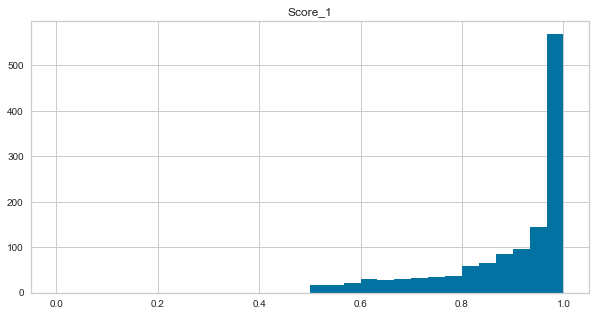

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

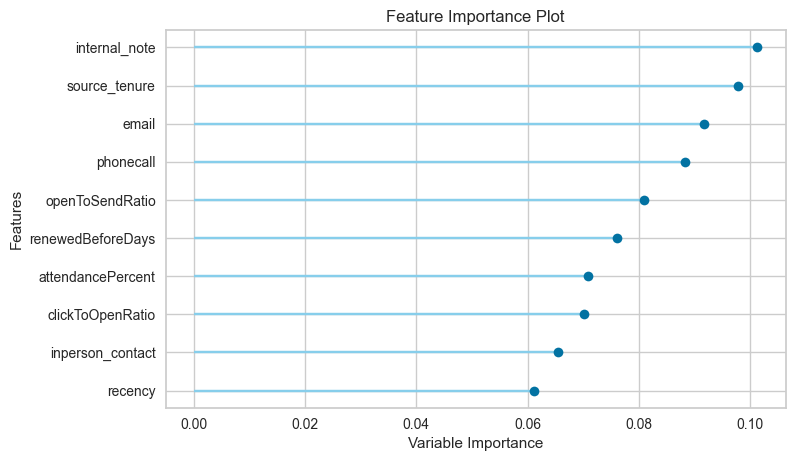

In [14]:
plot_model(best_model, plot='feature')

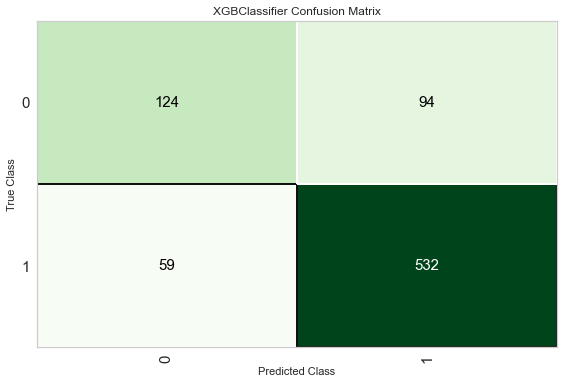

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

* The distribtution doesn't look normal 
* Touchpoint data has the first 3 features
* Ticketing data follows up at the next 4 features
* The model makes a lot more predictions of customers who will buy
* The accuracy decreased by 1% compared to using full season products only but AUC increased by 1%